In [1]:
import pandas as pd
import os
import s3fs
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

BUCKET = "cgadeau/Antoine Airdrop/"
FILE_KEY_S3 = "df_all_clusters_final.csv"
FILE_PATH_S3 = BUCKET + FILE_KEY_S3

with fs.open(FILE_PATH_S3, mode="rb") as file_in:
    dataset = pd.read_csv(file_in, sep=",")

In [2]:
with fs.open(BUCKET + "df_Données_Reabos_odd_final.csv", mode='rb') as file_in:
    bigdata = pd.read_csv(file_in, sep=',')
print(bigdata['ID_ABONNE'].nunique())

780796


In [3]:
print(dataset['ID_ABONNE'].nunique())
dataset

78079


,ID_ABONNE,DATE_ACTE_REEL,DATE_DEMARRAGE_PROMO,TYPE_PROMON,STATUT_FIN_M_MOINS_1,DATE_PRISE_EFFET,DATE_FIN_ABO_PREC,DATE_FIN_REABO,REGION,FORMULE_PREC,...,MOYEN_PAIEMENT,REABO_AVANT_ECHEANCE,DELAI_REABO,NB_APPARITIONS,MOY_DELAI,PREMIERE_APPARITION,ANCIENNETE,NOMBRE_ABONNEMENTS,SCORE_FIDELITE,Cluster_8
0,51276418001,2022-06-19,2022-06-19,ODD 30 jours TC,1.0,2022-06-19,2022-05-31,2022-09-18,Sénégal - Divers,AFRIQUE - EVASION & CANAL+,...,Cash,0,19,9,17.111111,2021-02-16,986,"[5, 4]",0.346154,4
1,51276418001,2021-12-01,2021-12-01,ODD 21 jours TC,0.0,2021-12-01,2021-08-23,2022-02-28,Sénégal - Divers,AFRIQUE - EVASION,...,Cash,0,100,9,17.111111,2021-02-16,986,"[5, 4]",0.346154,4
2,51276418001,2021-05-15,2021-05-15,ODD 15 jours TC,1.0,2021-05-15,2021-04-30,2021-06-14,Dakar,AFRIQUE - EVASION & CANAL+,...,Cash,0,15,9,17.111111,2021-02-16,986,"[5, 4]",0.346154,4
3,51276418001,2022-01-16,2022-01-16,ODD 15 jours TC,1.0,2022-03-01,2022-02-28,2022-05-31,Sénégal - Divers,AFRIQUE - EVASION & CANAL+,...,Cash,1,-43,9,17.111111,2021-02-16,986,"[5, 4]",0.346154,4
4,51276418001,2021-07-24,2021-07-24,ODD 15 jours TC,0.0,2021-07-24,2021-06-14,2021-08-23,Dakar,AFRIQUE - EVASION & CANAL+,...,Cash,0,40,9,17.111111,2021-02-16,986,"[5, 4]",0.346154,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946857,51458332904,2021-02-09,2021-02-09,PAS_ODD,1.0,2021-02-09,2021-02-07,2022-02-08,Dakar,AFRIQUE - EVASION & CANAL+,...,Cash,0,2,3,3.666667,2021-02-09,993,"[1, 1, 1]",0.076923,4
946858,51458332904,2023-02-16,2023-02-16,PAS_ODD,1.0,2023-02-16,2023-02-14,2024-02-15,Dakar,AFRIQUE - EVASION & CANAL+,...,Cash,0,2,3,3.666667,2021-02-09,993,"[1, 1, 1]",0.076923,4
946859,51720983201,2021-09-11,2021-10-01,PAS_ODD,1.0,2021-10-01,2021-09-30,2022-09-30,Dakar,AFRIQUE - ACCESS,...,Prélèvement RIB,1,-19,3,-19.000000,2021-09-11,779,"[1, 1, 1]",0.076923,4
946860,51720983201,2022-09-11,2022-10-01,PAS_ODD,1.0,2022-10-01,2022-09-30,2023-09-30,Dakar,AFRIQUE - ACCESS,...,Prélèvement RIB,1,-19,3,-19.000000,2021-09-11,779,"[1, 1, 1]",0.076923,4


In [4]:
def date_bascule(df, cluster):
    data = df.copy()
    data = data.loc[data["Cluster_8"] == cluster]
    data['DATE_PRISE_EFFET'] = pd.to_datetime(data['DATE_PRISE_EFFET'])
    data['ANNEE_MOIS'] = data['DATE_PRISE_EFFET'].dt.strftime('%Y-%m')
    result = data.groupby('ANNEE_MOIS')['ID_ABONNE'].nunique().reset_index()
    result.rename(columns={'ID_ABONNE' : 'NOMBRE_ABONNEMENTS'}, inplace = True)

    def ecart_type_avant_après(dataframe, line):
        result_before = dataframe.iloc[line:]
        result_after = dataframe.iloc[:line]
        std_before = result_before['NOMBRE_ABONNEMENTS'].std()
        mean_before = result_before['NOMBRE_ABONNEMENTS'].mean()
        std_after = result_after['NOMBRE_ABONNEMENTS'].std()
        mean_after = result_after['NOMBRE_ABONNEMENTS'].mean()
        return (std_before, std_after, mean_before, mean_after)

    min_std = float('inf')
    date = None
    min_std_before = None
    min_std_after = None
    the_mean_before = None
    the_mean_after = None
    for line in range(1, result.shape[0]):
        std_before, std_after, mean_before, mean_after = ecart_type_avant_après(result, line)
        std_line = std_before + std_after
        if min_std > std_line:
            min_std = std_line
            min_std_before = std_before
            min_std_after = std_after
            the_mean_before = mean_before
            the_mean_after = mean_after
            date = line
    
    ratio = the_mean_before/the_mean_after
    if ratio > 19/20 and ratio < 20/19 :
        date = None
        min_std_before = None
        min_std_after = None
        the_mean_before = None
        the_mean_after = None

    if date != None :
        mois_bascule = result.loc[date, 'ANNEE_MOIS']
        print('Date = ', mois_bascule)
    else :
        print('Date = ', date)
    print('Std error before = ', min_std_before)
    print('Std error after = ', min_std_after)
    print('Mean before = ', the_mean_before)
    print('Mean after = ', the_mean_after)
    print('Ecart des moyennes = ')

    return(result, mois_bascule)

liste_bascule = []
for i in range (0, 8, 1):
    print(i)
    liste_bascule += [date_bascule(dataset, i)[1]]
print(liste_bascule)

0
Date =  2021-09
Std error before =  1314.2953566894257
Std error after =  38.18376618407357
Mean before =  2388.730769230769
Mean after =  29.0
Ecart des moyennes = 
1
Date =  2022-07
Std error before =  419.1377607660756
Std error after =  772.4214789714683
Mean before =  1311.0625
Mean after =  3624.6666666666665
Ecart des moyennes = 
2
Date =  2021-07
Std error before =  2442.5056857932336
Std error after =  1716.4049250298328
Mean before =  4346.892857142857
Mean after =  3240.3333333333335
Ecart des moyennes = 
3
Date =  2021-05
Std error before =  1470.3906103911427
Std error after =  742.9762221408345
Mean before =  6352.933333333333
Mean after =  4773.5
Ecart des moyennes = 
4
Date =  2023-04
Std error before =  343.11992905438433
Std error after =  1470.2171041493611
Mean before =  1050.5714285714287
Mean after =  2456.222222222222
Ecart des moyennes = 
5
Date =  2021-12
Std error before =  1998.8416260048725
Std error after =  69.37518768743381
Mean before =  3958.130434782

In [5]:
def find_periods(df, cluster):

    data = df.copy()
    data = data.loc[data["Cluster_8"] == cluster]
    data['DATE_PRISE_EFFET'] = pd.to_datetime(data['DATE_PRISE_EFFET'])
    result = data.groupby(['DATE_PRISE_EFFET', 'TYPE_PROMON'])['ID_ABONNE'].nunique().reset_index()
    result.rename(columns={'ID_ABONNE' : 'NOMBRE_ABONNEMENTS'}, inplace = True)

    
    
    # Calculer la moyenne mobile sur une fenêtre glissante pour chaque TYPE_PROMON
    window_size = 7  # Taille de la fenêtre glissante pour la moyenne mobile
    df['rolling_mean'] = df.groupby('TYPE_PROMON')['NOMBRE_ABONNEMENTS'].transform(lambda x: x.rolling(window_size).mean())

    # Identifier les périodes où une promotion est significativement plus élevée que les autres
    # Par exemple, vous pouvez définir un seuil pour déterminer ce qui constitue une augmentation significative
    seuil = 1.5  # Changer cela selon vos besoins
    promotions_significatives = df[df['NOMBRE_ABONNEMENTS'] > seuil * df['rolling_mean']]

    # Afficher les dates qui délimitent ces périodes
    dates_limites = promotions_significatives['DATE_PRISE_EFFET'].unique()

    print("Les dates limites des périodes où une promotion est significativement plus utilisée que les autres sont :", dates_limites)


    return result


find_periods(dataset, 0)

DataError: No numeric types to aggregate

In [6]:
def create_dataset_all_dates(df, cluster):

    data = df.copy()
    data = data.loc[data["Cluster_8"] == cluster]
    """
    data.rename(columns={'DATE_PRISE_EFFET' : 'NOUVEAU_NOM'}, inplace = True)
    data.rename(columns={'DATE_ACTE_REEL' : 'DATE_PRISE_EFFET'}, inplace = True)
    """
    data['DATE_PRISE_EFFET'] = pd.to_datetime(data['DATE_PRISE_EFFET'])
    result = data.groupby(['DATE_PRISE_EFFET', 'TYPE_PROMON'])['ID_ABONNE'].nunique().reset_index()
    result.rename(columns={'ID_ABONNE' : 'NOMBRE_ABONNEMENTS'}, inplace = True)

    
    # Création d'un DataFrame contenant toutes les dates et tous les types promon possibles
    min_date = result['DATE_PRISE_EFFET'].min()
    max_date = result['DATE_PRISE_EFFET'].max()
    all_dates = pd.date_range(start=min_date, end=max_date, freq='D')
    all_promotions = result['TYPE_PROMON'].unique()
    all_possible_combinations = pd.MultiIndex.from_product([all_dates, all_promotions], names=['DATE_PRISE_EFFET', 'TYPE_PROMON'])
    df_all_combinations = pd.DataFrame(index=all_possible_combinations).reset_index()

    # Fusion avec votre DataFrame initial pour remplir les valeurs manquantes
    merged_df = pd.merge(df_all_combinations, result, on=['DATE_PRISE_EFFET', 'TYPE_PROMON'], how='left')

    # Remplacement des valeurs manquantes de NOMBRE_ABONNEMENTS par 0
    merged_df['NOMBRE_ABONNEMENTS'] = merged_df['NOMBRE_ABONNEMENTS'].fillna(0)

    return merged_df
print(create_dataset_all_dates(dataset, 0))
create_dataset_all_dates(dataset, 0)


     DATE_PRISE_EFFET               TYPE_PROMON  NOMBRE_ABONNEMENTS
0          2021-07-30           ODD 15 jours TC                 2.0
1          2021-07-30  ODD 7 jours autre que SG                 0.0
2          2021-07-30          ODD 15 jours EV+                 0.0
3          2021-07-30         Semaine genéreuse                 0.0
4          2021-07-30           ODD 21 jours TC                 0.0
...               ...                       ...                 ...
7411       2023-10-31           ODD 21 jours TC                13.0
7412       2023-10-31           ODD 30 jours TC                 0.0
7413       2023-10-31                   PAS_ODD                 0.0
7414       2023-10-31          ODD 30 jours EV+                 0.0
7415       2023-10-31                    Autres                 0.0

[7416 rows x 3 columns]


,DATE_PRISE_EFFET,TYPE_PROMON,NOMBRE_ABONNEMENTS
0,2021-07-30,ODD 15 jours TC,2.0
1,2021-07-30,ODD 7 jours autre que SG,0.0
2,2021-07-30,ODD 15 jours EV+,0.0
3,2021-07-30,Semaine genéreuse,0.0
4,2021-07-30,ODD 21 jours TC,0.0
...,...,...,...
7411,2023-10-31,ODD 21 jours TC,13.0
7412,2023-10-31,ODD 30 jours TC,0.0
7413,2023-10-31,PAS_ODD,0.0
7414,2023-10-31,ODD 30 jours EV+,0.0


In [7]:
def find_periods(data, cluster):
    df = create_dataset_all_dates(data, cluster)

    # Étape 1 : Identifier les périodes où le nombre d'abonnements est significativement plus élevé que la moyenne ou la médiane
    periodes_significatives = {}
    for promotion, series in df.groupby('TYPE_PROMON'):
        # Calculer la moyenne ou la médiane de la série temporelle
        mean = series['NOMBRE_ABONNEMENTS'].mean()
        # Remplacer mean par median pour utiliser la médiane
        std = series['NOMBRE_ABONNEMENTS'].std()
        seuil = mean + 2 * std  # Choisir un seuil approprié en fonction de votre analyse
        # Identifier les périodes où le nombre d'abonnements dépasse le seuil
        periodes_significatives[promotion] = series[series['NOMBRE_ABONNEMENTS'] > seuil]

    # Étape 2 : Fusionner les périodes consécutives avec le même TYPE_PROMON
    merged_periodes = {}
    for promotion, periodes in periodes_significatives.items():
        current_start = None
        current_end = None
        for index, row in periodes.iterrows():
            if current_start is None:
                current_start = row['DATE_PRISE_EFFET']
                current_end = row['DATE_PRISE_EFFET']
            elif row['DATE_PRISE_EFFET'] == current_end + pd.Timedelta(days=1):
                current_end = row['DATE_PRISE_EFFET']
            else:
                if promotion not in merged_periodes:
                    merged_periodes[promotion] = []
                merged_periodes[promotion].append((current_start, current_end))
                current_start = row['DATE_PRISE_EFFET']
                current_end = row['DATE_PRISE_EFFET']
        if current_start is not None:
            if promotion not in merged_periodes:
                merged_periodes[promotion] = []
            merged_periodes[promotion].append((current_start, current_end))

    # Étape 3 : Fusionner les périodes qui se chevauchent avec des TYPE_PROMON différents
    final_periodes = []
    for promotion, periodes in merged_periodes.items():
        for periode in periodes:
            if not final_periodes:
                final_periodes.append((promotion, periode[0], periode[1]))
            else:
                last_promotion, last_start, last_end = final_periodes[-1]
                if last_end >= periode[0] and last_promotion != promotion:
                    final_periodes[-1] = (last_promotion + " / " + promotion, min(last_start, periode[0]), max(last_end, periode[1]))
                else:
                    final_periodes.append((promotion, periode[0], periode[1]))

    # Étape 4 : Affichez les périodes résultantes avec les TYPE_PROMON et les nombres d'abonnements associés
    for promotion, debut_periode, fin_periode in final_periodes:
        periode_df = df[(df['DATE_PRISE_EFFET'] >= debut_periode) & (df['DATE_PRISE_EFFET'] <= fin_periode) & (df['TYPE_PROMON'].str.contains(promotion))]
        total_abonnements = periode_df['NOMBRE_ABONNEMENTS'].sum()
        print(f"Période significative pour {promotion} du {debut_periode} au {fin_periode}, Nombre total d'abonnements : {total_abonnements}")
    return

for i in range (0, 8, 1):
    find_periods(dataset, i)

Période significative pour Autres du 2022-06-02 00:00:00 au 2022-06-10 00:00:00, Nombre total d'abonnements : 165.0
Période significative pour Autres du 2022-06-12 00:00:00 au 2022-06-22 00:00:00, Nombre total d'abonnements : 110.0
Période significative pour Autres du 2022-06-25 00:00:00 au 2022-06-30 00:00:00, Nombre total d'abonnements : 58.0
Période significative pour Autres / ODD 15 jours EV+ / ODD 15 jours EV+ / ODD 15 jours EV+ / ODD 15 jours EV+ / ODD 15 jours EV+ / ODD 15 jours EV+ / ODD 15 jours EV+ / ODD 15 jours EV+ / ODD 15 jours EV+ / ODD 15 jours TC / ODD 15 jours TC / ODD 15 jours TC / ODD 15 jours TC / ODD 15 jours TC / ODD 15 jours TC / ODD 15 jours TC / ODD 15 jours TC / ODD 15 jours TC / ODD 15 jours TC / ODD 15 jours TC / ODD 15 jours TC / ODD 15 jours TC / ODD 15 jours TC / ODD 15 jours TC / ODD 15 jours TC / ODD 15 jours TC / ODD 15 jours TC du 2022-01-01 00:00:00 au 2023-08-01 00:00:00, Nombre total d'abonnements : 0.0
Période significative pour ODD 15 jours TC /

On va faire le tableau d'Antoine

In [8]:
def find_percent(df):
    """
    Détermine le pourcentage d'abonnés dans le cluster
    """
    data = df.copy()
    total_abonnes = data['ID_ABONNE'].nunique()

    pourcentages_clusters = {}
    for cluster in range(0, 8, 1):
        abonnes_cluster = data[data['Cluster_8'] == cluster]['ID_ABONNE'].nunique()
        pourcentage_cluster = (abonnes_cluster / total_abonnes) * 100
        pourcentages_clusters[cluster] = pourcentage_cluster

    # Afficher les pourcentages associés à chaque cluster
    for cluster, pourcentage in pourcentages_clusters.items():
        print(f"Cluster {cluster}: {pourcentage:.2f}%")
    return pourcentages_clusters

find_percent(dataset)

Cluster 0: 13.45%
Cluster 1: 9.04%
Cluster 2: 14.02%
Cluster 3: 13.07%
Cluster 4: 16.04%
Cluster 5: 10.96%
Cluster 6: 11.96%
Cluster 7: 11.47%


{0: 13.446637380089395,
 1: 9.035720232072645,
 2: 14.016572958157763,
 3: 13.066253410007814,
 4: 16.040164448827472,
 5: 10.963255164640941,
 6: 11.95840110657155,
 7: 11.472995299632425}

In [9]:
def create_periods(date_debut, nb_periods, periode_length_months):
    """Crée les périodes en fonction de la date de début, du nombre de périodes et de la longueur de chaque période en mois."""
    periods = []
    for i in range(nb_periods):
        debut_periode = date_debut + timedelta(days=periode_length_months * 30 * i)
        fin_periode = debut_periode + timedelta(days=periode_length_months * 30)
        periods += [(debut_periode, fin_periode)]
    return periods

def calculate_abonnements_moyens(datata, periods):
    """Calcule le nombre d'abonnements moyens par jour de disponibilité pour chaque cluster sur chaque période."""
    df = datata.copy()
    df['DATE_PRISE_EFFET'] = pd.to_datetime(df['DATE_PRISE_EFFET'])
    nombre_abonnements_moyens = {}
    for cluster, group in df.groupby('Cluster_8'):
        cluster_abonnements_moyens = {}
        for i, (debut_periode, fin_periode) in enumerate(periods, start=1):
            print('Cluster ', cluster, 'période ', i, (debut_periode, fin_periode))
            periode_data = group[(group['DATE_PRISE_EFFET'] >= debut_periode) & (group['DATE_PRISE_EFFET'] < fin_periode)]
            #abonnements_periode = periode_data.groupby('ID_ABONNE')['DATE_PRISE_EFFET'].nunique().count()
            abonnements_periode = periode_data.shape[0]
            print('abonnements_periode :',abonnements_periode)
            if i < 6:
                jours_disponibilite = 6 * periode_data['ID_ABONNE'].nunique()
            elif i == 6:
                jours_disponibilite = 4 * periode_data['ID_ABONNE'].nunique()

            print('jours_disponibilite : ', jours_disponibilite)
            if jours_disponibilite > 0:
                abonnements_moyens_periode = abonnements_periode / jours_disponibilite
            else:
                abonnements_moyens_periode = 0
            cluster_abonnements_moyens[f'Période {i}'] = abonnements_moyens_periode
        nombre_abonnements_moyens[cluster] = cluster_abonnements_moyens
    return nombre_abonnements_moyens

# Définir la date de début et le nombre de périodes
date_debut = datetime.strptime('2021-01-01', '%Y-%m-%d')
nb_periods = 6
periode_length_months = 6

# Créer les périodes
periods = create_periods(date_debut, nb_periods, periode_length_months)
print(periods)

calculate_abonnements_moyens(dataset, periods)


[(datetime.datetime(2021, 1, 1, 0, 0), datetime.datetime(2021, 6, 30, 0, 0)), (datetime.datetime(2021, 6, 30, 0, 0), datetime.datetime(2021, 12, 27, 0, 0)), (datetime.datetime(2021, 12, 27, 0, 0), datetime.datetime(2022, 6, 25, 0, 0)), (datetime.datetime(2022, 6, 25, 0, 0), datetime.datetime(2022, 12, 22, 0, 0)), (datetime.datetime(2022, 12, 22, 0, 0), datetime.datetime(2023, 6, 20, 0, 0)), (datetime.datetime(2023, 6, 20, 0, 0), datetime.datetime(2023, 12, 17, 0, 0))]
Cluster  0 période  1 (datetime.datetime(2021, 1, 1, 0, 0), datetime.datetime(2021, 6, 30, 0, 0))
abonnements_periode : 0
jours_disponibilite :  0
Cluster  0 période  2 (datetime.datetime(2021, 6, 30, 0, 0), datetime.datetime(2021, 12, 27, 0, 0))
abonnements_periode : 3504
jours_disponibilite :  14310
Cluster  0 période  3 (datetime.datetime(2021, 12, 27, 0, 0), datetime.datetime(2022, 6, 25, 0, 0))
abonnements_periode : 16850
jours_disponibilite :  49392
Cluster  0 période  4 (datetime.datetime(2022, 6, 25, 0, 0), dateti

{0: {'Période 1': 0,
  'Période 2': 0.2448637316561845,
  'Période 3': 0.3411483641075478,
  'Période 4': 0.33732601962759806,
  'Période 5': 0.3588232607007446,
  'Période 6': 0.3783490566037736},
 1: {'Période 1': 0.6908693540553666,
  'Période 2': 0.550201417571771,
  'Période 3': 0.5680896271972184,
  'Période 4': 0.4370940170940171,
  'Période 5': 0.4597405775819873,
  'Période 6': 0.5268630849220104},
 2: {'Période 1': 0.4029274200283972,
  'Période 2': 0.38376507744515004,
  'Période 3': 0.4705891634321058,
  'Période 4': 0.42605400284225486,
  'Période 5': 0.47395110670630985,
  'Période 6': 0.43076628841004716},
 3: {'Période 1': 0.638110790101746,
  'Période 2': 0.5973631178057861,
  'Période 3': 0.7108356380877123,
  'Période 4': 0.6265542328042328,
  'Période 5': 0.689389338731444,
  'Période 6': 0.6456884561891516},
 4: {'Période 1': 0.35348183037320513,
  'Période 2': 0.2861167940849216,
  'Période 3': 0.3015029247256735,
  'Période 4': 0.2641629535327817,
  'Période 5': 

In [10]:
def find_mean_with_promo(df):
    data = df.copy()
    # Grouper les données par CLUSTER_8 et TYPE_PROMON
    grouped_data = data.groupby(['Cluster_8', 'TYPE_PROMON'])

    # Initialiser des dictionnaires pour stocker les résultats
    nombre_interventions = {}
    nombre_dates_differentes = {}
    nombre_reabo_par_jour_dispo = {}

    # Boucler à travers chaque groupe
    for (cluster, type_promo), group in grouped_data:
        # Nombre de fois que TYPE_PROMON i intervient dans le cluster_8 j
        nombre_intervention = len(group)
        # Nombre de DATE_PRISE_EFFET différentes auxquelles TYPE_PROMON i intervient dans le cluster_8 j
        nombre_dates_diff = group['DATE_PRISE_EFFET'].nunique()
        
        # Stocker les résultats dans les dictionnaires
        if cluster not in nombre_interventions:
            nombre_interventions[cluster] = {}
            nombre_dates_differentes[cluster] = {}
            nombre_reabo_par_jour_dispo[cluster] = {}
        nombre_interventions[cluster][type_promo] = nombre_intervention
        nombre_dates_differentes[cluster][type_promo] = nombre_dates_diff
        nombre_reabo_par_jour_dispo[cluster][type_promo] = nombre_intervention/nombre_dates_diff

    # Afficher les résultats
    for cluster, interventions in nombre_interventions.items():
        print(f"Cluster {cluster}:")
        for type_promo, nb_interventions in interventions.items():
            nb_dates_diff = nombre_dates_differentes[cluster][type_promo]
            print(f"  - Type promotion {type_promo}:")
            #print(f"      Nombre d'interventions : {nb_interventions}")
            #print(f"      Nombre de dates différentes : {nb_dates_diff}")
            print(f"      Nombre de réabonnements moyens par jour de disponibilité : {nb_interventions/nb_dates_diff}")
    return nombre_reabo_par_jour_dispo

find_mean_with_promo(dataset)

Cluster 0:
  - Type promotion Autres:
      Nombre de réabonnements moyens par jour de disponibilité : 6.5
  - Type promotion ODD 15 jours EV+:
      Nombre de réabonnements moyens par jour de disponibilité : 2.8225806451612905
  - Type promotion ODD 15 jours TC:
      Nombre de réabonnements moyens par jour de disponibilité : 55.17304189435337
  - Type promotion ODD 21 jours TC:
      Nombre de réabonnements moyens par jour de disponibilité : 11.206030150753769
  - Type promotion ODD 30 jours EV+:
      Nombre de réabonnements moyens par jour de disponibilité : 19.560439560439562
  - Type promotion ODD 30 jours TC:
      Nombre de réabonnements moyens par jour de disponibilité : 13.387434554973822
  - Type promotion ODD 7 jours autre que SG:
      Nombre de réabonnements moyens par jour de disponibilité : 6.732342007434944
  - Type promotion PAS_ODD:
      Nombre de réabonnements moyens par jour de disponibilité : 15.927272727272728
  - Type promotion Semaine genéreuse:
      Nombre d

{0: {'Autres': 6.5,
  'ODD 15 jours EV+': 2.8225806451612905,
  'ODD 15 jours TC': 55.17304189435337,
  'ODD 21 jours TC': 11.206030150753769,
  'ODD 30 jours EV+': 19.560439560439562,
  'ODD 30 jours TC': 13.387434554973822,
  'ODD 7 jours autre que SG': 6.732342007434944,
  'PAS_ODD': 15.927272727272728,
  'Semaine genéreuse': 17.189228529839884},
 1: {'Autres': 5.051282051282051,
  'ODD 15 jours EV+': 6.784722222222222,
  'ODD 15 jours TC': 36.646814404432135,
  'ODD 21 jours TC': 3.890932982917214,
  'ODD 30 jours EV+': 11.285123966942148,
  'ODD 30 jours TC': 10.476190476190476,
  'ODD 7 jours autre que SG': 1.651685393258427,
  'PAS_ODD': 15.5546875,
  'Semaine genéreuse': 49.26271186440678},
 2: {'Autres': 11.012820512820513,
  'ODD 15 jours EV+': 9.801204819277109,
  'ODD 15 jours TC': 106.06803594351733,
  'ODD 21 jours TC': 5.796653796653796,
  'ODD 30 jours EV+': 25.765690376569037,
  'ODD 30 jours TC': 22.948529411764707,
  'ODD 7 jours autre que SG': 2.638888888888889,
  '

On crée le df qui regroupe toutes les informations

In [12]:
dataset_cluster_explanations = pd.DataFrame({'Cluster': list(range(8))})

dataset_cluster_explanations['Pourcentage de la population'] = dataset_cluster_explanations['Cluster'].map(find_percent(dataset))
dataset_cluster_explanations["Dico"] = dataset_cluster_explanations['Cluster'].map(find_mean_with_promo(dataset))
print(dataset['TYPE_PROMON'].unique())
for promo in dataset['TYPE_PROMON'].unique():
    dataset_cluster_explanations[f"Abonnement par jour pour {promo}"] = dataset_cluster_explanations["Dico"].apply(lambda x: x[promo])

for promo in dataset['TYPE_PROMON'].unique():
    dataset_cluster_explanations[f"Abonnement par jour pour {promo}"] = dataset_cluster_explanations[f"Abonnement par jour pour {promo}"] / dataset_cluster_explanations["Abonnement par jour pour Semaine genéreuse"]


dataset_cluster_explanations.drop(columns = ['Dico'], inplace = True)

dataset_cluster_explanations["Periods"] = dataset_cluster_explanations['Cluster'].map(calculate_abonnements_moyens(dataset, periods))
print(dataset_cluster_explanations)
for i in range(1, 7, 1):
    dataset_cluster_explanations[f"Taux d'abonnement sur la période {i}"] = dataset_cluster_explanations["Periods"].apply(lambda x: x[f"Période {i}"])
dataset_cluster_explanations.drop(columns = ['Periods'], inplace = True)



# Enregistrer la figure dans un fichier
nom_fichier_temporaire = 'clusters_explanation.csv'
dataset_cluster_explanations.to_csv(nom_fichier_temporaire, index=False)
# Enregistrer le fichier temporaire sur S3
with fs.open(BUCKET + nom_fichier_temporaire, mode='wb') as file_out:
    with open(nom_fichier_temporaire, 'rb') as temp_file:
        file_out.write(temp_file.read())
# Supprimer le fichier temporaire
os.remove(nom_fichier_temporaire)

dataset_cluster_explanations

Cluster 0: 13.45%
Cluster 1: 9.04%
Cluster 2: 14.02%
Cluster 3: 13.07%
Cluster 4: 16.04%
Cluster 5: 10.96%
Cluster 6: 11.96%
Cluster 7: 11.47%
Cluster 0:
  - Type promotion Autres:
      Nombre de réabonnements moyens par jour de disponibilité : 6.5
  - Type promotion ODD 15 jours EV+:
      Nombre de réabonnements moyens par jour de disponibilité : 2.8225806451612905
  - Type promotion ODD 15 jours TC:
      Nombre de réabonnements moyens par jour de disponibilité : 55.17304189435337
  - Type promotion ODD 21 jours TC:
      Nombre de réabonnements moyens par jour de disponibilité : 11.206030150753769
  - Type promotion ODD 30 jours EV+:
      Nombre de réabonnements moyens par jour de disponibilité : 19.560439560439562
  - Type promotion ODD 30 jours TC:
      Nombre de réabonnements moyens par jour de disponibilité : 13.387434554973822
  - Type promotion ODD 7 jours autre que SG:
      Nombre de réabonnements moyens par jour de disponibilité : 6.732342007434944
  - Type promotion PA

,Cluster,Pourcentage de la population,Abonnement par jour pour ODD 30 jours TC,Abonnement par jour pour ODD 21 jours TC,Abonnement par jour pour ODD 15 jours TC,Abonnement par jour pour Semaine genéreuse,Abonnement par jour pour PAS_ODD,Abonnement par jour pour ODD 7 jours autre que SG,Abonnement par jour pour ODD 15 jours EV+,Abonnement par jour pour ODD 30 jours EV+,Abonnement par jour pour Autres,Taux d'abonnement sur la période 1,Taux d'abonnement sur la période 2,Taux d'abonnement sur la période 3,Taux d'abonnement sur la période 4,Taux d'abonnement sur la période 5,Taux d'abonnement sur la période 6
0,0,13.446637,0.778827,0.651922,3.209745,1.0,15.927273,6.732342,2.822581,19.560440,6.500000,0.000000,0.244864,0.341148,0.337326,0.358823,0.378349
1,1,9.035720,0.212660,0.078983,0.743906,1.0,15.554688,1.651685,6.784722,11.285124,5.051282,0.690869,0.550201,0.568090,0.437094,0.459741,0.526863
2,2,14.016573,0.674758,0.170440,3.118731,1.0,37.029240,2.638889,9.801205,25.765690,11.012821,0.402927,0.383765,0.470589,0.426054,0.473951,0.430766
3,3,13.066253,0.214024,0.023981,1.052692,1.0,19.220930,1.853448,7.714286,24.723549,10.810811,0.638111,0.597363,0.710836,0.626554,0.689389,0.645688
4,4,16.040164,0.697026,0.741004,2.357311,1.0,16.036585,3.940000,11.455479,12.350785,4.344262,0.353482,0.286117,0.301503,0.264163,0.275111,0.359195
5,5,10.963255,0.195292,0.040490,1.077458,1.0,5.646465,3.127193,3.496104,11.968326,6.947368,0.000000,0.236330,0.538534,0.527848,0.733764,0.698412
6,6,11.958401,0.676392,0.219324,2.166466,1.0,5.620000,4.807339,5.258065,2.043478,3.942308,0.000000,0.000000,0.166667,0.264563,0.389463,0.523973
7,7,11.472995,0.113799,0.008577,0.663863,1.0,10.017241,1.250000,6.693694,20.873874,10.598361,0.817978,0.823364,0.869513,0.785427,0.842046,0.833578


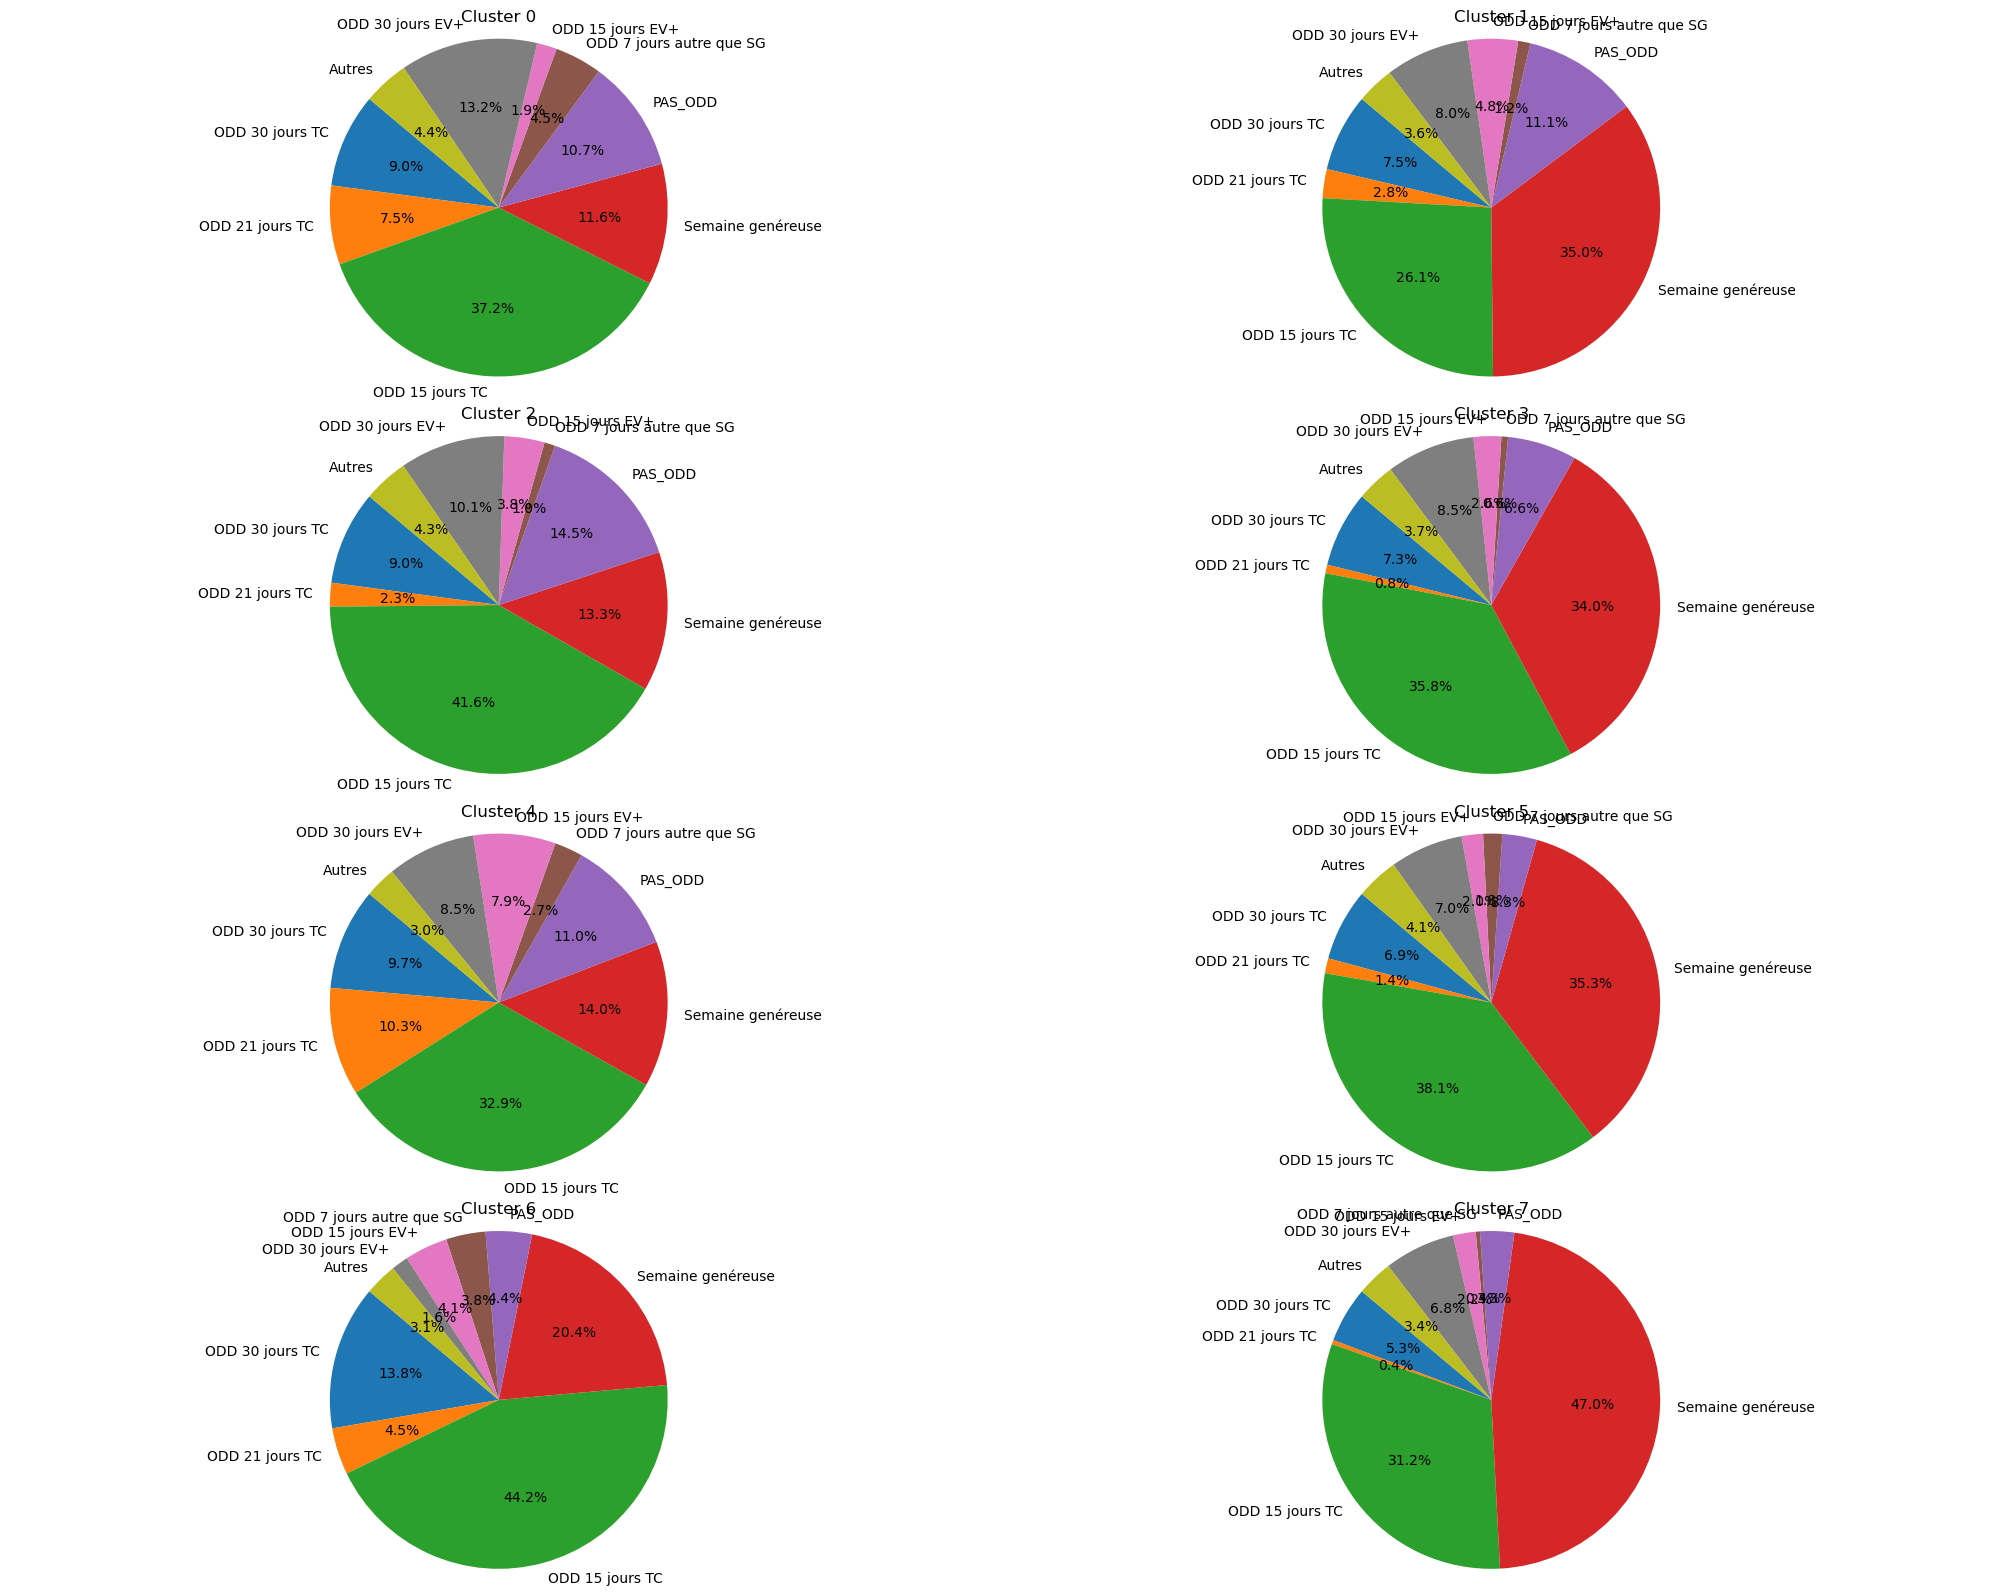

In [ ]:
# Boucler à travers chaque ligne du DataFrame
liste_promotions = list(dataset['TYPE_PROMON'].unique())

# Créer une nouvelle figure
fig = plt.figure(figsize=(20, 16))

# Boucler à travers chaque ligne du DataFrame
for index, row in dataset_cluster_explanations.iterrows():
    # Créer une liste de valeurs des colonnes 'Abonnement par jour pour{promo}'
    valeurs_promotions = [row[f"Abonnement par jour pour {promo}"] for promo in liste_promotions]
    
    # Ajouter un sous-plot à la figure pour le graphe camembert
    ax = fig.add_subplot(4, 2, index + 1)
    ax.pie(valeurs_promotions, labels=liste_promotions, autopct='%1.1f%%', startangle=140)
    ax.axis('equal')  # Assurer un aspect circulaire
    ax.set_title(f'Cluster {int(row["Cluster"])}')

# Ajuster la disposition pour éviter les chevauchements
fig.tight_layout()

# Enregistrer la figure dans un fichier
nom_fichier_temporaire = 'graph_camembert_clusters.png'
plt.savefig(nom_fichier_temporaire)

# Enregistrer le fichier temporaire sur S3
with fs.open(BUCKET + nom_fichier_temporaire, mode='wb') as file_out:
    with open(nom_fichier_temporaire, 'rb') as temp_file:
        file_out.write(temp_file.read())

# Supprimer le fichier temporaire
os.remove(nom_fichier_temporaire)

# Afficher la figure
plt.show()

[0.0, 0.2448637316561845, 0.3411483641075478, 0.33732601962759806, 0.3588232607007446, 0.3783490566037736]
[0.6908693540553666, 0.550201417571771, 0.5680896271972184, 0.4370940170940171, 0.4597405775819873, 0.5268630849220104]
[0.4029274200283972, 0.38376507744515004, 0.4705891634321058, 0.42605400284225486, 0.47395110670630985, 0.43076628841004716]
[0.638110790101746, 0.5973631178057861, 0.7108356380877123, 0.6265542328042328, 0.689389338731444, 0.6456884561891516]
[0.35348183037320513, 0.2861167940849216, 0.3015029247256735, 0.2641629535327817, 0.2751114033165315, 0.35919540229885055]
[0.0, 0.23632958801498127, 0.5385339276869737, 0.5278483992467043, 0.7337644025461284, 0.6984116390816871]
[0.0, 0.0, 0.16666666666666666, 0.2645631067961165, 0.3894629924041689, 0.523973073224344]
[0.8179775280898877, 0.8233642394090155, 0.8695125135205699, 0.7854266860530142, 0.8420458026960784, 0.8335777126099707]


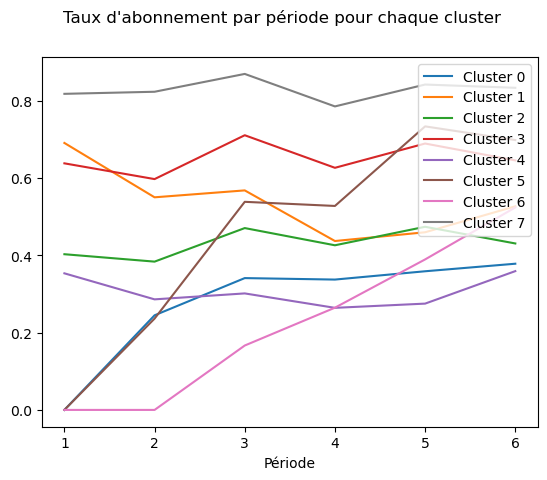

In [ ]:
"""Trace les courbes de taux d'abonnement pour chaque cluster."""
for cluster in range(0, 8, 1):
    X = range(1, 7, 1)

    # Sélectionner la ligne correspondant au cluster 'Cluster1'
    cluster_row = dataset_cluster_explanations.loc[dataset_cluster_explanations['Cluster'] == cluster]
    # Extraire les valeurs des 6 dernières colonnes
    Y = (cluster_row.iloc[:, -6:].values.tolist())[0]
    print(Y)

    plt.plot(X, Y, label = f"Cluster {cluster}")

# Ajouter un titre global et un label pour l'axe x
plt.xlabel("Période")
plt.suptitle("Taux d'abonnement par période pour chaque cluster")
plt.legend(loc='upper right')

# Enregistrer la figure dans un fichier
nom_fichier_temporaire = 'graph_taux_abonnement.png'
plt.savefig(nom_fichier_temporaire)

# Enregistrer le fichier temporaire sur S3
with fs.open(BUCKET + nom_fichier_temporaire, mode='wb') as file_out:
    with open(nom_fichier_temporaire, 'rb') as temp_file:
        file_out.write(temp_file.read())

# Supprimer le fichier temporaire
os.remove(nom_fichier_temporaire)

# Afficher le graphe
plt.show()

In [ ]:
dataset['DATE_PRISE_EFFET'].min(), dataset['DATE_PRISE_EFFET'].max()

('2021-01-01', '2023-10-31')